In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import BinaryCrossentropy
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'


In [3]:
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [4]:
#так как данные очень не сбалансированные, мы возьмем только часть отрицательных случаев
df_0=train[train['target']==0].sample(3000) 
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

In [5]:
train, test, y_train, y_test = train_test_split(train['image_name'], train['target'], test_size=0.2, random_state=42)
train = pd.DataFrame(train, columns=['image_name'])
train['target'] = y_train
test = pd.DataFrame(test, columns=['image_name'])

In [6]:
#подготавливаем данные, создаем дф с соответствием картинки и таргета
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

In [7]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(train_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

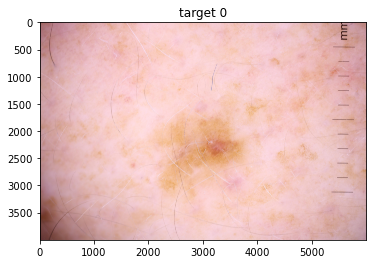

In [8]:
#ознакомимся с картинками

img_0 = tf.keras.preprocessing.image.load_img(
    df.loc[df['target'] == 0].iloc[0]['images'], grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest"
)

img_0_np = np.asarray(img_0)
plt.imshow(img_0_np)
plt.title('target 0')
plt.show()

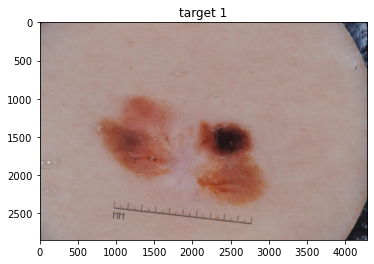

In [9]:
img_1 = tf.keras.preprocessing.image.load_img(
    df.loc[df['target'] == 1].iloc[0]['images'], grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest"
)

img_1_np = np.asarray(img_1)
plt.imshow(img_1_np)
plt.title('target 1')
plt.show()

In [10]:
#создаем генератор для загрузки данных, выделяем валидационный сет
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, 
    validation_split = 0.2)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='raw',
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    class_mode='raw',
    subset='validation')

Found 2294 validated image filenames.
Found 573 validated image filenames.


In [11]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 3.8 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
import efficientnet.tfkeras as efn

In [13]:
#создаем модель на основе натренерованой сети EfficientNetB3
def efn_model( num_classes=None):

    model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x=MaxPooling2D()(model.output)
    x2=Flatten()(x)
    output=Dense(1,activation='sigmoid')(x2)
    model=Model(model.input,output)
    
    return model

efn_conv=efn_model(1)

44113920/44107200 [==============================] - 2s 0us/step


In [14]:
efn_conv.compile(loss=BinaryCrossentropy(), metrics=[tf.keras.metrics.AUC()],optimizer=Adam())

In [15]:
nb_epochs = 5
batch_size=8
nb_train_steps = df.shape[0]*0.8//batch_size
nb_val_steps=df.shape[0]*0.2//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 286.0 and 71.0


Epoch 1/5
286/286 [==============================] - 1313s 5s/step - loss: 0.5005 - auc: 0.6966 - val_loss: 0.3847 - val_auc: 0.8113
Epoch 2/5
286/286 [==============================] - 1315s 5s/step - loss: 0.4195 - auc: 0.7642 - val_loss: 0.3619 - val_auc: 0.8203
Epoch 3/5
286/286 [==============================] - 1303s 5s/step - loss: 0.3879 - auc: 0.7950 - val_loss: 0.3424 - val_auc: 0.8369
Epoch 4/5
286/286 [==============================] - 1317s 5s/step - loss: 0.3746 - auc: 0.8041 - val_loss: 0.3532 - val_auc: 0.8318
Epoch 5/5
286/286 [==============================] - 1343s 5s/step - loss: 0.3964 - auc: 0.7798 - val_loss: 0.3232 - val_auc: 0.8574


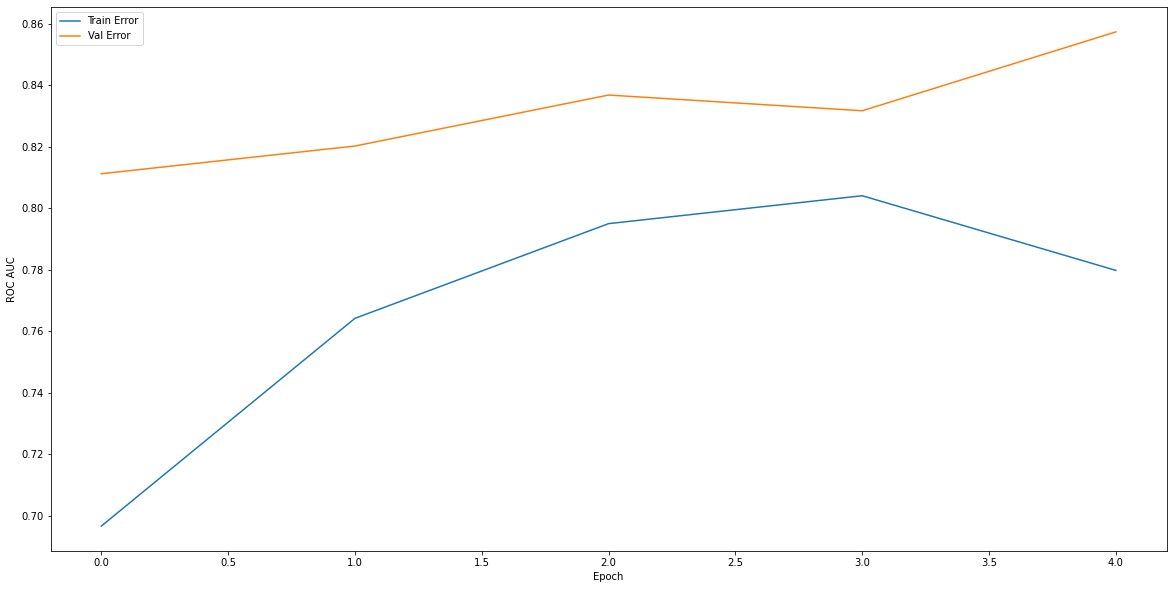

In [16]:
history = efn_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    validation_steps=nb_val_steps
)


plt.rcParams['figure.figsize'] = [20, 10]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.plot(hist['epoch'], hist['auc'], label='Train Error')
plt.plot(hist['epoch'], hist['val_auc'], label = 'Val Error')
plt.legend()

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='images',
    class_mode=None,
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
)

Found 717 validated image filenames.


In [18]:
predict = efn_conv.predict_generator(test_generator, steps = len(test_generator.filenames))

In [19]:
roc_auc_score(y_test, predict)

0.8648579143628649

In [20]:
#скорректируем результаты, добавив ответы из модели логистической регрессии по метаданным
pr_lr = pd.read_csv('../input/melanoma-git/submission_lr.csv')
pr_all = predict*0.9+pr_lr.values*0.1
roc_auc_score(y_test, pr_all)

0.8648418413269898